# Applying Knn on our dataset.

* Step 1: Split the data into training and test data.
* Step 2: Converting the text into vectors(using all four techniques BoW, tfidf, avg word-2 vec and tfidf word-2 vec.
* Step 3: Applying Knn on the training data.
* Step 4: Performing hyper parameter tuning to find the best value of hyperparameter(k).
* Step 5: Now plot Acurracy vs hyperparameters for different value of hyperparamter for crossvalidation and training data.
* Step 6: Now train your model with this value of hyperparameter(k).
* Step 7: Now plot the ROC curve for trainig and test data, for given value of hyperparameter.
* Step 8: Now create confusion matrix.

**Note: Repeat these all Steps for all word embedding technique and then also using kd-tree**

In [1]:
# importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec


In [2]:
#reading dataframe

df=pd.read_csv(r'D:\study material\ML\Datasets\amazon-fine-food-reviews\Reviews_cleaned.csv')
df.head()

,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Clean_Text,clean_summary
0,B001E4KFG0,A3SGXH7AUHU8GW,1,1,1,1303862400,bought several vitality canned dog food produc...,good quality dog food
1,B00813GRG4,A1D87F6ZCVE5NK,0,0,0,1346976000,product arrived labeled jumbo salted peanut pe...,not advertised
2,B000LQOCH0,ABXLMWJIXXAIN,1,1,1,1219017600,confection around century light pillowy citrus...,delight say
3,B000UA0QIQ,A395BORC6FGVXV,3,3,0,1307923200,looking secret ingredient robitussin believe f...,cough medicine
4,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,1,1350777600,great taffy great price wide assortment yummy ...,great taffy


In [3]:
# now sampling 8000 points with equal number of positve and negative class
pos_pts=df[df['Score']==1].sample(n=4000,random_state=21)
neg_pts=df[df['Score']==0].sample(n=4000,random_state=21)
df=pd.concat([pos_pts,neg_pts])
df['Time'] = pd.to_datetime(df['Time'], origin='unix', unit='s')
df.sort_values('Time',inplace=True)

In [4]:
df['Score'].value_counts()

1    4000
0    4000
Name: Score, dtype: int64

In [5]:
#changing the name of column 
df.rename(columns={'Clean_Text':'Text','clean_summary':'Summary'},inplace=True)

In [6]:
df.fillna('',inplace=True)

In [7]:
# Spliting the dataframe into train,and test dataset.
X_train,X_test,y_train,y_test=train_test_split(df['Text'],df['Score'],test_size=0.3,random_state=42)

In [8]:
n=len(y_test)
k=0
for i in y_test:
    if i==1:
        k+=1
print("No of postive points in test set :",k,"\nNo of negative points in training data :",n-k)

No of postive points in test set : 1185 
No of negative points in training data : 1215


In [9]:
#Shape of dataframes
print("The shape of the train and test datasets :",X_train.shape,X_test.shape,y_train.shape,y_test.shape)

The shape of the train and test datasets : (5600,) (2400,) (5600,) (2400,)


# 1. Applying Knn with Bow

## 1.1 Spliiting data into test and train and applyinng knn with default parameters

In [10]:
# applying Bag of words on both test and training data
def conv_bow(X_train,X_test):
    count_vect=CountVectorizer(ngram_range=(1,2),min_df=10,max_features=3000)
    X_train_vect=count_vect.fit_transform(X_train)
    X_test_vect=count_vect.transform(X_test)
    return X_train_vect,X_test_vect

In [11]:
X_train_vect,X_test_vect=conv_bow(X_train,X_test)

In [12]:
X_train_vect.shape

(5600, 3000)

In [13]:
X_test_vect.shape

(2400, 3000)

In [14]:
X_train_vect=X_train_vect.toarray()
X_test_vect=X_test_vect.toarray()

In [15]:
#Applying knn on the data with default values
knn=KNeighborsClassifier(algorithm='brute')
knn.fit(X_train_vect,y_train.ravel())
knn.score(X_test_vect,y_test.ravel())

0.6204166666666666

## 1.2 K-Fold Cross Validation :
* Performing 10-fold cross validation on the training data.

In [16]:
#using cross validation to find the best hyperparameters
acc=[]
param_k=list(range(1,100,3))
for i in tqdm(param_k):
    knn.n_neighbors=i
    sco=cross_val_score(knn,X_train_vect,y_train.ravel(),cv=10,scoring='accuracy')
    acc.append(1-np.mean(sco))

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [03:30<00:00,  6.59s/it]


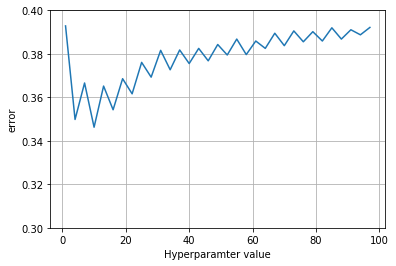

In [17]:
#ploting graph between hyperparameter-k and error for each vaue of k.
sns.lineplot(param_k,acc)
plt.xlabel("Hyperparamter value")
plt.ylim(0.3,0.4)
plt.ylabel("error")
plt.grid()
plt.show()

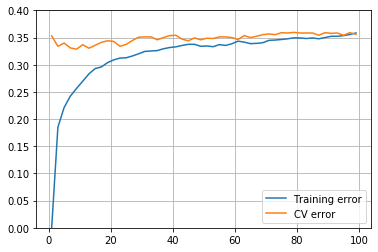

In [18]:
X_tr,X_cv,y_tr,y_cv=train_test_split(X_train,y_train,test_size=0.3,random_state=42)
X_tr,X_cv=conv_bow(X_tr,X_cv)
train_error=[]
test_error=[]
for i in range(1,100,2):
    knn.n_neighbors=i
    knn.fit(X_tr,y_tr.ravel())
    y_pred_tr=knn.predict(X_tr)
    y_pred_cv=knn.predict(X_cv)
    train_error.append(1-accuracy_score(y_tr,y_pred_tr))
    test_error.append(1-accuracy_score(y_cv,y_pred_cv))
    
sns.lineplot(list(range(1,100,2)),train_error,label='Training error')
sns.lineplot(list(range(1,100,2)),test_error,label="CV error")
plt.grid()
plt.ylim(0.0,0.4)
plt.show()


## 1.3 Grid-Search CV :
* Using Grid-Search CV to find the best hyperparams 

In [19]:
params={'n_neighbors':list(range(1,20))}
clf=GridSearchCV(knn,params,cv=10,n_jobs=-1,scoring='accuracy')
clf.fit(X_train_vect,y_train.ravel())

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=99, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [20]:
best_pram=clf.best_params_
best_pram

{'n_neighbors': 10}

In [21]:
clf.best_score_

0.65375

In [22]:
#accuracy of best parameter
knn.n_neighbors=best_pram['n_neighbors']
# clf.best_params_['n_neighbors']
knn.fit(X_train_vect,y_train.ravel())
knn.score(X_test_vect,y_test.ravel())

0.6345833333333334

# Conclusion (Hyperparameter Tuning):
* so when use K-Fold Cross validation for finding the best value of hyper_paramter k , we saw that the error is minimum at k=10.
* Same way we performed grid search CV on our dataset and it automatically returns the best hyperparamter between the range we have entered.

## 1.4 ROC curve and AUC :

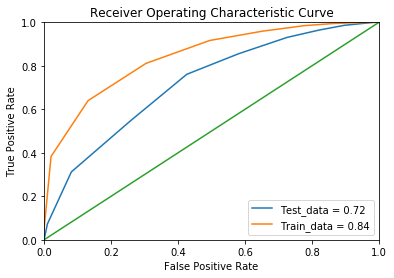

In [23]:
# Drawing Roc curve for both training and test data 
probs1 = knn.predict_proba(X_test_vect)[:,1]
probs2 = knn.predict_proba(X_train_vect)[:,1]

fpr1, tpr1, threshold = roc_curve(y_test, probs1)
fpr2, tpr2, threshold = roc_curve(y_train, probs2)
roc_auc1=roc_auc_score(y_test,probs1)
roc_auc2=roc_auc_score(y_train,probs2)

plt.title('Receiver Operating Characteristic Curve')
sns.lineplot(fpr1, tpr1, label = 'Test_data = {:0.2f}'.format(roc_auc1))
sns.lineplot(fpr2, tpr2, label = 'Train_data = {:0.2f}'.format(roc_auc2))
sns.lineplot([0, 1], [0, 1])
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## 1.5 Confusion Matrix

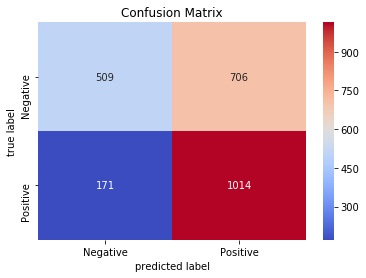

In [24]:
y_pred=knn.predict(X_test_vect)
con=confusion_matrix(y_test,y_pred)
# con[0]=(con[0]*100)/np.sum(con[0])
# con[1]=(con[1]*100)/np.sum(con[1])
con=pd.DataFrame(con,index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(con,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix')
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

In [25]:
y_pred=knn.predict(X_test_vect)
print("Precision Score",precision_score(y_test,y_pred))

Precision Score 0.5895348837209302


In [26]:
print("Recall Score",recall_score(y_test,y_pred))

Recall Score 0.8556962025316456


In [27]:
print('F1 score',f1_score(y_test,y_pred))

F1 score 0.6981067125645439


# 2.1 Applying Knn with Tfidf 

In [28]:
def tfidf(X_train,X_test):
    tfidf=TfidfVectorizer(ngram_range=(1,2),max_features=5000,min_df=10)
    a=tfidf.fit_transform(X_train).toarray()
    b=tfidf.transform(X_test).toarray()
    return a,b

In [29]:
X_train_vect,X_test_vect=tfidf(X_train,X_test)

In [30]:
X_train_vect.shape

(5600, 3528)

In [31]:
X_test_vect.shape

(2400, 3528)

In [32]:
y_train.shape

(5600,)

In [33]:
y_test.shape

(2400,)

In [34]:
#Applying knn on the data with default values
knn=KNeighborsClassifier(algorithm='brute')
knn.fit(X_train_vect,y_train.ravel())
knn.score(X_test_vect,y_test.ravel())

0.6695833333333333

# 2.2 K-Fold Cross Validation :
* Performing 10-fold cross validation on the training data.

In [35]:
#using cross validation to find the best hyperparameters
acc=[]
param_k=list(range(1,1000,10))
for i in tqdm(param_k):
    knn.n_neighbors=i
    sco=cross_val_score(knn,X_train_vect,y_train.ravel(),cv=10,scoring='accuracy')
    acc.append(np.mean(sco))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [12:52<00:00,  8.05s/it]


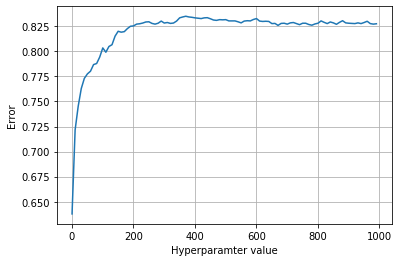

In [36]:
#ploting graph between hyperparameter-k and accuracy for each vaue of k.
sns.lineplot(param_k,acc)
plt.xlabel("Hyperparamter value")
plt.ylabel("Error")
plt.grid()
plt.show()

In [37]:
X_tr,X_cv,y_tr,y_cv=train_test_split(X_train,y_train,test_size=0.3,random_state=42)
X_tr,X_cv=conv_bow(X_tr,X_cv)
train_error=[]
test_error=[]
for i in tqdm(range(1,1000,20)):
    knn.n_neighbors=i
    knn.fit(X_tr,y_tr.ravel())
    y_pred_tr=knn.predict(X_tr)
    y_pred_cv=knn.predict(X_cv)
    train_error.append(1-accuracy_score(y_tr,y_pred_tr))
    test_error.append(1-accuracy_score(y_cv,y_pred_cv))
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:28<00:00,  1.98s/it]


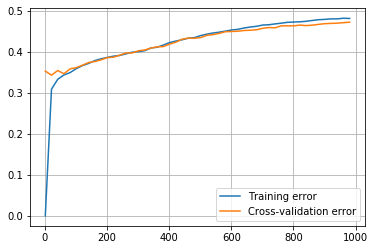

In [38]:
sns.lineplot(list(range(1,1000,20)),train_error,label='Training error')
sns.lineplot(list(range(1,1000,20)),test_error,label="Cross-validation error")
plt.grid()
plt.show()

# 2.3 Grid-Search CV :
* Using Grid-Search CV to find the best hyperparams 

In [39]:
params={'n_neighbors':list(range(1,1000,20))}
clf=GridSearchCV(knn,params,cv=10,n_jobs=-1,scoring='accuracy')
clf.fit(X_train_vect,y_train.ravel())

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=981, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 21, 41, 61, 81, 101, 121, 141, 161,
                                         181, 201, 221, 241, 261, 281, 301, 321,
                                         341, 361, 381, 401, 421, 441, 461, 481,
                                         501, 521, 541, 561, 581, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [40]:
x=clf.best_params_
x

{'n_neighbors': 361}

In [41]:
#accuracy of best parameter
knn.n_neighbors=361
knn.fit(X_train_vect,y_train.ravel())
knn.score(X_test_vect,y_test.ravel())

0.82375

# 2.4 ROC curve and AUC :

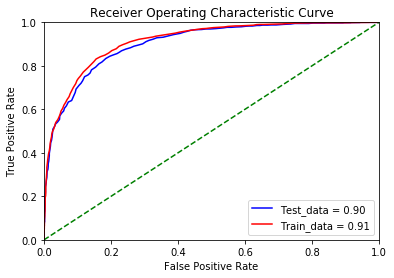

In [42]:

# Drawing Roc curve for both training and test data 
probs1 = knn.predict_proba(X_test_vect)[:,1]
probs2 = knn.predict_proba(X_train_vect)[:,1]

fpr1, tpr1, threshold = roc_curve(y_test, probs1)
fpr2, tpr2, threshold = roc_curve(y_train, probs2)
roc_auc1=roc_auc_score(y_test,probs1)
roc_auc2=roc_auc_score(y_train,probs2)

plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr1, tpr1, 'b', label = 'Test_data = {:0.2f}'.format(roc_auc1))
plt.plot(fpr2, tpr2, 'b', label = 'Train_data = {:0.2f}'.format(roc_auc2),c='r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# 2.5 Confusion Matrix:

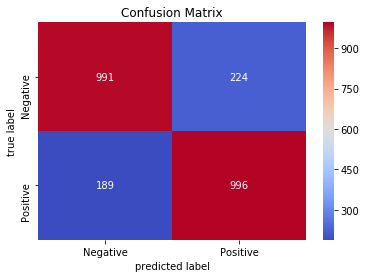

In [43]:
# now using k=10 to train our model and 
knn.n_neighbors=431
knn.fit(X_train_vect,y_train.ravel())
# knn.score(X_test_vect,y_test.ravel())
P=np.sum(y_test)
N=len(y_test)-P
y_pred=knn.predict(X_test_vect)
con=confusion_matrix(y_test,y_pred)
# con[0]=(con[0]*100)/np.sum(con[0])
# con[1]=(con[1]*100)/np.sum(con[1])
con=pd.DataFrame(con,index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(con,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix')
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

In [44]:
y_pred=knn.predict(X_test_vect)
print("Precision Score",precision_score(y_test,y_pred))

Precision Score 0.8163934426229508


In [45]:

print("Recall Score",recall_score(y_test,y_pred))

Recall Score 0.8405063291139241


In [46]:
print('F1 score',f1_score(y_test,y_pred))

F1 score 0.8282744282744282


# 3.1 Applying knn with word-2-vec

In [47]:
def conv_w2v(list_of_sent):
    word_vect=[]
    for sent in tqdm(list_of_sent):
        temp=np.zeros(50)
        count_words=0
        for word in sent:
            if word in w2v_model.wv:
                temp+=w2v_model.wv[word]
                count_words+=1
        if count_words:
            word_vect.append(temp/count_words)
    return word_vect

In [48]:
def con_list_of_sent(arr):
    sent=[]
    for i in arr:
        sent.append(i.split())
    return sent


In [49]:

list_of_sent=con_list_of_sent(df['Text'])
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
#converting training data into w2v 
list_of_sent=con_list_of_sent(X_train)
X_train_vect=conv_w2v(list_of_sent)

#converting test data into w2v
list_of_sent=con_list_of_sent(X_test)
X_test_vect=conv_w2v(list_of_sent)



100%|████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:00<00:00, 7083.80it/s]


In [50]:
# applying knn brute force
knn=KNeighborsClassifier()
knn.fit(X_train_vect,y_train)
knn.score(X_test_vect,y_test)

0.65625

# 3.2 Applying K-fold cross validation

In [51]:
#using cross validation to find the best hyperparameters
acc=[]
param_k=list(range(1,100))
for i in tqdm(param_k):
    knn.n_neighbors=i
    sco=cross_val_score(knn,X_train_vect,y_train.ravel(),cv=10,scoring='accuracy')
    acc.append(np.mean(sco))

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [04:02<00:00,  3.23s/it]


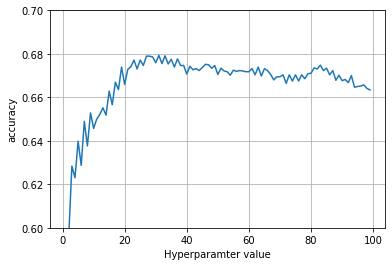

In [52]:
#ploting graph between hyperparameter-k and accuracy for each vaue of k.
sns.lineplot(param_k,acc)
plt.xlabel("Hyperparamter value")
plt.ylabel("accuracy")
plt.ylim(0.6,0.7)
plt.grid()
plt.show()

In [53]:
X_tr,X_cv,y_tr,y_cv=train_test_split(X_train,y_train,test_size=0.3,random_state=42)
X_tr,X_cv=list_of_sent=con_list_of_sent(X_tr),con_list_of_sent(X_cv)
X_tr_vect,X_cv_vect=conv_w2v(X_tr),conv_w2v(X_cv)
train_error=[]
test_error=[]
for i in tqdm(range(1,100,2)):
    knn.n_neighbors=i
    knn.fit(X_tr_vect,y_tr)
    y_pred_tr=knn.predict(X_tr_vect)
    y_pred_cv=knn.predict(X_cv_vect)
    train_error.append(1-accuracy_score(y_tr,y_pred_tr))
    test_error.append(1-accuracy_score(y_cv,y_pred_cv))
    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:49<00:00,  2.30s/it]


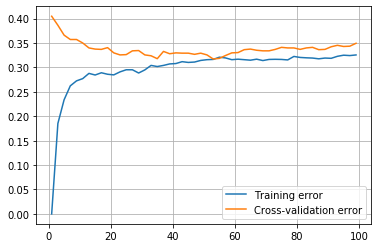

In [54]:
sns.lineplot(list(range(1,100,2)),train_error,label='Training error')
sns.lineplot(list(range(1,100,2)),test_error,label="Cross-validation error")
plt.grid()
plt.show()

# 3.3 Grid Search CV


In [55]:
params={'n_neighbors':list(range(1,60,2))}
clf=GridSearchCV(knn,params,cv=10,n_jobs=-1,scoring='accuracy')
clf.fit(X_train_vect,y_train.ravel())

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=99, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23, 25, 27, 29, 31, 33, 35, 37, 39, 41,
                                         43, 45, 47, 49, 51, 53, 55, 57, 59]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [56]:
x=clf.best_params_
x

{'n_neighbors': 31}

In [57]:
#accuracy of best parameter
knn.n_neighbors=47
knn.fit(X_train_vect,y_train.ravel())
knn.score(X_test_vect,y_test.ravel())

0.6829166666666666

# 3.4 ROC curve and AUC :


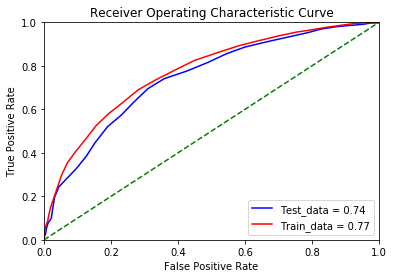

In [58]:

# Drawing Roc curve for both training and test data 
probs1 = knn.predict_proba(X_test_vect)[:,1]
probs2 = knn.predict_proba(X_train_vect)[:,1]

fpr1, tpr1, threshold = roc_curve(y_test, probs1)
fpr2, tpr2, threshold = roc_curve(y_train, probs2)
roc_auc1=roc_auc_score(y_test,probs1)
roc_auc2=roc_auc_score(y_train,probs2)

plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr1, tpr1, 'b', label = 'Test_data = {:0.2f}'.format(roc_auc1))
plt.plot(fpr2, tpr2, 'b', label = 'Train_data = {:0.2f}'.format(roc_auc2),c='r')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# 3.5 Confusion Matrix

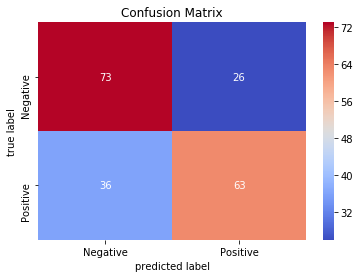

In [59]:
# now using k=10 to train our model and 
# knn.n_neighbors=3
# knn.fit(X_train_vect,y_train.ravel())
# knn.score(X_test_vect,y_test.ravel())
P=np.sum(y_test)
N=len(y_test)-P
y_pred=knn.predict(X_test_vect)
con=confusion_matrix(y_test,y_pred)
con[0]=(con[0]*100)/np.sum(con[0])
con[1]=(con[1]*100)/np.sum(con[1])
con=pd.DataFrame(con,index=['Negative','Positive'],columns=['Negative','Positive'])
sns.heatmap(con,annot=True,fmt='d',cmap='coolwarm')
plt.title('Confusion Matrix')
plt.xlabel("predicted label")
plt.ylabel("true label")
plt.show()

In [60]:
y_pred=knn.predict(X_test_vect)
print("Precision Score",precision_score(y_test,y_pred))
print("Recall Score",recall_score(y_test,y_pred))
print('F1 score',f1_score(y_test,y_pred))

Precision Score 0.6977611940298507
Recall Score 0.6312236286919831
F1 score 0.6628267611874168


In [61]:
import winsound
frequency =500# Set Frequency To 2500 Hertz
duration = 1000 # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)